# Testing ClusterDE - Optimized null data

In [32]:
import pandas as pd
import scanpy as sc
import anndata as ad
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse as sps
from scipy.stats import ranksums, spearmanr, kendalltau

import os
#Loading the rpy2 extension enables cell magic to be used
#This runs R code in jupyter notebook cells
os.environ['R_HOME'] = '/Library/Frameworks/R.framework/Resources'
r_path = "/Library/Frameworks/R.framework/Resources/bin"
os.environ["PATH"] = r_path + ";" + os.environ["PATH"]

import anndata2ri
anndata2ri.activate()
%load_ext rpy2.ipython
    
import BacSC.util_probe as up
import BacSC.util as ut
import BacSC.NB_est as nb
import BacSC.countsplit as cs
import BacSC.ClusterDE as cd

import warnings
warnings.filterwarnings("ignore")

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [33]:
import importlib

## Preprocessing
### Read data

In [34]:
data_gene = sc.read_h5ad("../../data/MOBA_scRNAseq/outs_S2/filtered_data_maxpool_processed.h5ad")


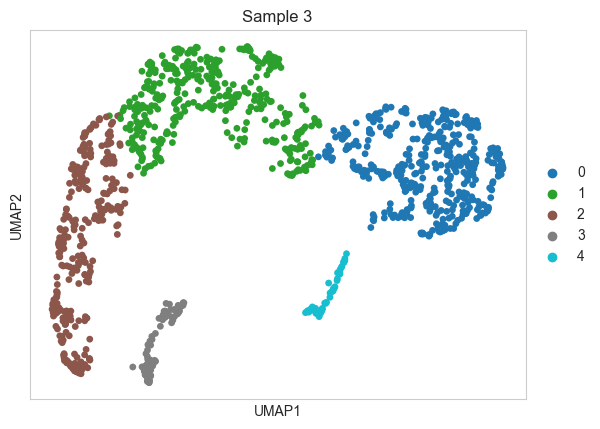

In [35]:
sc.tl.leiden(data_gene, resolution=0.15, key_added="leiden_opt", random_state=1234)
sc.pl.umap(data_gene, color="leiden_opt", palette="tab10", title="Sample 3")
plt.show()

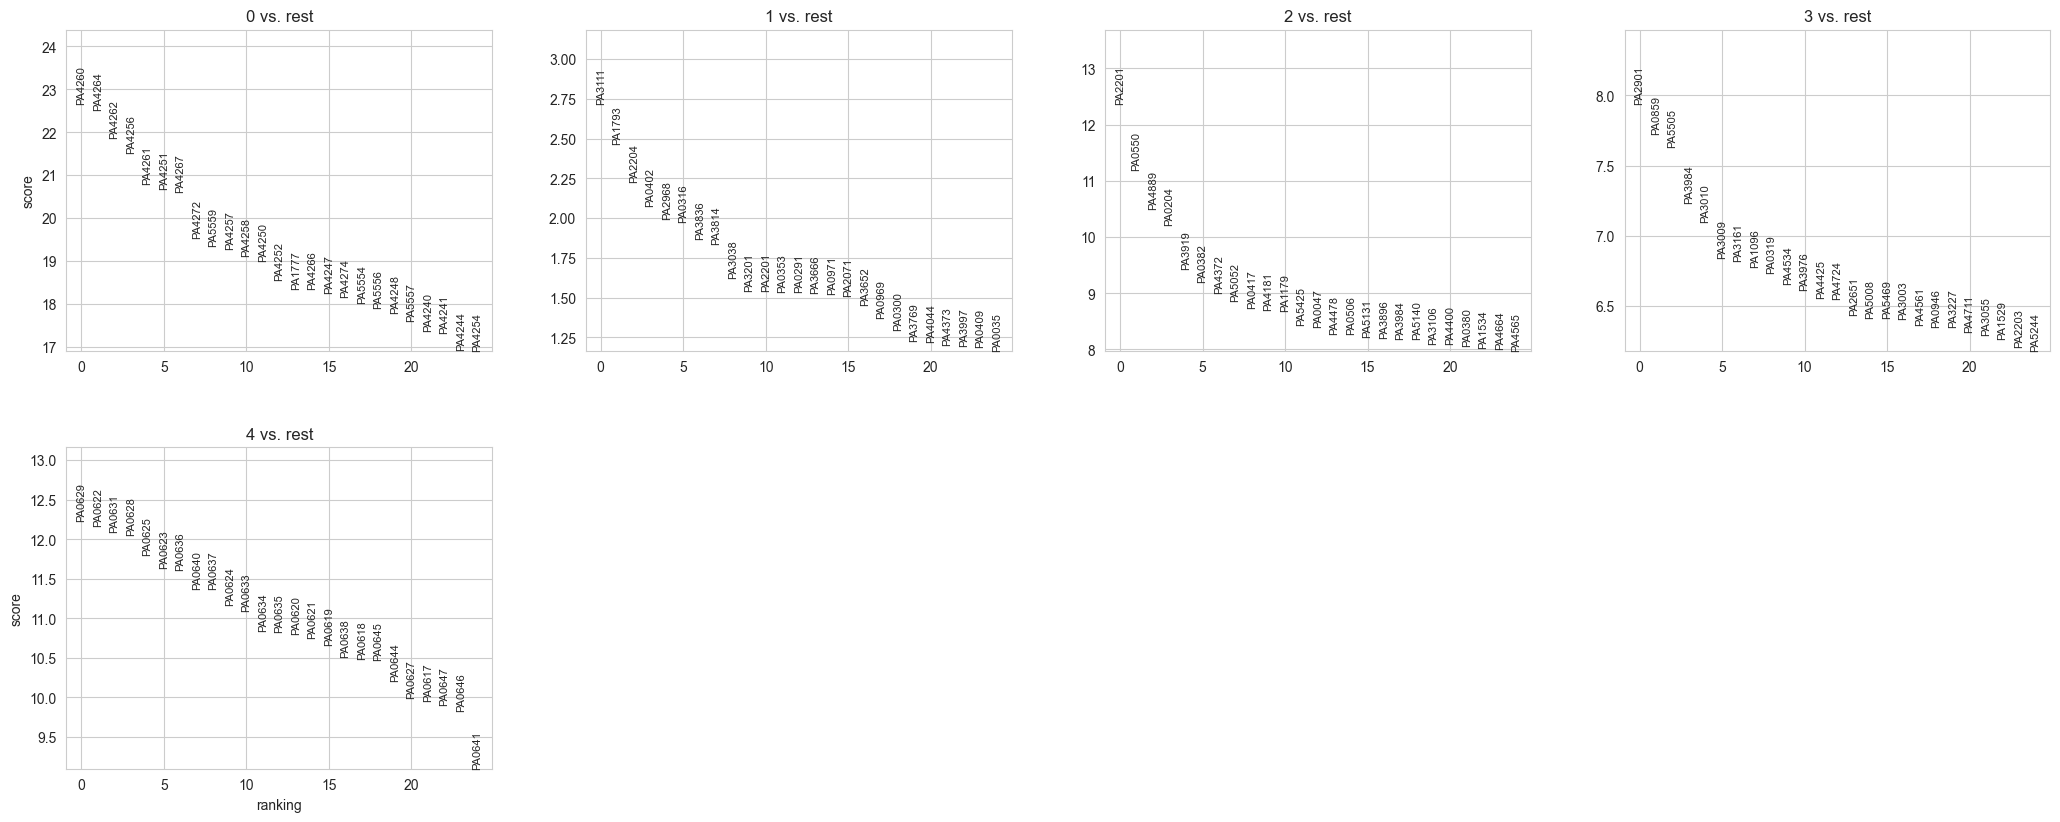

In [36]:
sc.tl.rank_genes_groups(data_gene, 'leiden_opt', method='wilcoxon')
sc.pl.rank_genes_groups(data_gene, n_genes=25, sharey=False)

In [37]:
from statsmodels.discrete.count_model import NegativeBinomialP, ZeroInflatedNegativeBinomialP

count_data = data_gene.layers["counts"].toarray()
n, p = count_data.shape

init_zinfs = [len(count_data[:, i][count_data[:, i] == 0]) / n for i in range(p)]
init_means = [np.log(np.mean(count_data[:, i][count_data[:, i] != 0]))
              # if init_zinfs[i] > 0.65 else np.log(np.mean(count_data[:, i]))
              for i in range(p)]
init_ods = [(np.var(count_data[:, i][count_data[:, i] > 0]) - np.mean(count_data[:, i][count_data[:, i] > 0])) / (np.mean(count_data[:, i][count_data[:, i] > 0]))**2
            # if init_zinfs[i] > 0.65 else np.var(count_data[:, i]) - np.mean(count_data[:, i])
            for i in range(p)]

i = 5248
dat = count_data[:, i]

model_nb = NegativeBinomialP(dat, np.ones(n))
res_nb = model_nb.fit(method='bfgs', maxiter=5000,
                      # start_params=[init_means[i], init_ods[i]]
                      )

print(res_nb.summary())

model_zinb = ZeroInflatedNegativeBinomialP(dat, np.ones(n))
res_zinb = model_zinb.fit(method='bfgs', maxiter=5000, start_params=[init_zinfs[i], init_means[i], init_ods[i]])
print(res_zinb.summary())

print(res_nb.converged)

Optimization terminated successfully.
         Current function value: 0.901931
         Iterations: 3
         Function evaluations: 5
         Gradient evaluations: 5
                     NegativeBinomialP Regression Results                     
Dep. Variable:                      y   No. Observations:                 1255
Model:              NegativeBinomialP   Df Residuals:                     1254
Method:                           MLE   Df Model:                            0
Date:                Mon, 25 Mar 2024   Pseudo R-squ.:               1.235e-11
Time:                        08:11:18   Log-Likelihood:                -1131.9
converged:                       True   LL-Null:                       -1131.9
Covariance Type:            nonrobust   LLR p-value:                       nan
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.7805      0.046    -17.0

### Load and process null data

In [38]:
data_null_gen = sc.read_h5ad("../../data/MOBA_scRNAseq/outs_S2/S2_null_data_opt.h5ad")

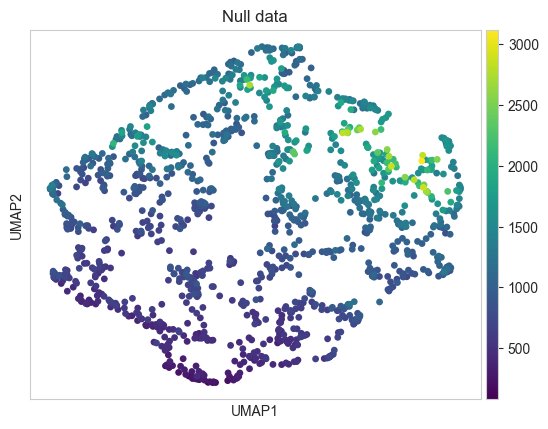

In [39]:

sc.pl.umap(data_null_gen, color="total_counts", alpha=1, cmap="viridis", title="Null data")
plt.show()

In [40]:
print(data_null_gen.var["gene_dist"].value_counts())
#print(data_gene.var["gene_dist"].value_counts())


gene_dist
nb     4905
poi     635
Name: count, dtype: int64


In [41]:
res2 = 0.105
sc.tl.leiden(data_null_gen, resolution=res2, key_added="leiden", random_state=1234)
nclust = len(data_null_gen.obs["leiden"].unique())
print(nclust)

2


In [42]:
res2 = 0.01
twoclust = False

while twoclust is False:
    if (res2 * 100)%5 == 0:
        print(res2)
    res2 += 0.005
    res2 = np.round(res2, 3)
    sc.tl.leiden(data_null_gen, resolution=res2, key_added="leiden", random_state=1234)
    nclust = len(data_null_gen.obs["leiden"].unique())
    if nclust == 2:
        twoclust = True
    
    
print(f"Resolution for two clusters: {res2}")

0.05
Resolution for two clusters: 0.08


In [43]:
X_null_gen_0 = data_null_gen.X[data_null_gen.obs["leiden"] == "0"]
X_null_gen_1 = data_null_gen.X[data_null_gen.obs["leiden"] != "0"]

pval_null_gen = pd.DataFrame({"pval_null": ranksums(X_null_gen_0, X_null_gen_1, alternative="two-sided").pvalue}, index=data_null_gen.var.index)

clusters = data_gene.obs["leiden_opt"].unique()


In [44]:
DEs_log_gen = {}
pvals_log_gen = {}
fdr = 0.05

for c in clusters:
    X_data_0 = data_gene.X[data_gene.obs["leiden_opt"] == c].copy()
    X_data_1 = data_gene.X[data_gene.obs["leiden_opt"] != c].copy()
    p_data = pd.DataFrame({"pval_data": ranksums(X_data_0, X_data_1, alternative="two-sided").pvalue}, index=data_gene.var.index)
    DE_TU, pval_TU = cd.call_de(p_data, pval_null_gen, FDR=fdr, correct=False, nlog=True)
    data_gene.var[f"pval_cluster_{c}_gen"] = pval_TU["pval_data"]
    data_gene.var[f"q_cluster_{c}_gen"] = pval_TU["q"]
    data_gene.var[f"DE_cluster_{c}_gen"] = (data_gene.var[f"q_cluster_{c}_gen"] < fdr)
    
    DEs_log_gen[c] = DE_TU
    pvals_log_gen[c] = pval_TU
    print(f"Cluster {c} - DE genes: {len(DEs_log_gen[c])}; Minimum q value: {np.min(pvals_log_gen[c]['q'])}")

Cluster 0 - DE genes: 121; Minimum q value: 0.015625
Cluster 1 - DE genes: 0; Minimum q value: 1.0
Cluster 2 - DE genes: 0; Minimum q value: 0.09446022727272728
Cluster 3 - DE genes: 0; Minimum q value: 0.5146067415730337
Cluster 4 - DE genes: 0; Minimum q value: 1.0


In [45]:
DEs_gen = {}
pvals_gen = {}
fdr = 0.05

for c in clusters:
    X_data_0 = data_gene.X[data_gene.obs["leiden_opt"] == c].copy()
    X_data_1 = data_gene.X[data_gene.obs["leiden_opt"] != c].copy()
    p_data = pd.DataFrame({"pval_data": ranksums(X_data_0, X_data_1, alternative="two-sided").pvalue}, index=data_gene.var.index)
    DE_TU, pval_TU = cd.call_de(p_data, pval_null_gen, FDR=fdr, correct=False, nlog=False)
    data_gene.var[f"pval_cluster_{c}_gen"] = pval_TU["pval_data"]
    data_gene.var[f"q_cluster_{c}_gen"] = pval_TU["q"]
    data_gene.var[f"DE_cluster_{c}_gen"] = (data_gene.var[f"q_cluster_{c}_gen"] < fdr)
    
    DEs_gen[c] = DE_TU
    pvals_gen[c] = pval_TU
    print(f"Cluster {c} - DE genes: {len(DEs_gen[c])}; Minimum q value: {np.min(pvals_gen[c]['q'])}")

Cluster 0 - DE genes: 3566; Minimum q value: 0.032047089601046436
Cluster 1 - DE genes: 0; Minimum q value: 1.0
Cluster 2 - DE genes: 201; Minimum q value: 0.04411764705882353
Cluster 3 - DE genes: 0; Minimum q value: 0.375
Cluster 4 - DE genes: 0; Minimum q value: 1.0


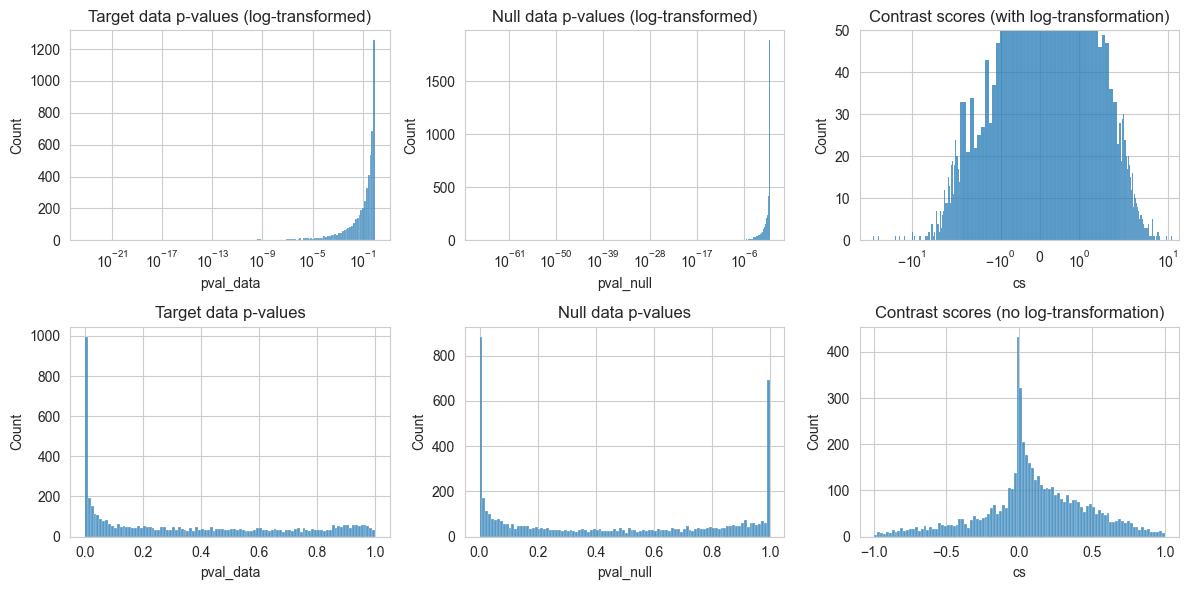

In [46]:
c = "3"

fig, ax = plt.subplots(2, 3, figsize=(12,6))
sns.histplot(pvals_log_gen[c], x="pval_data", ax=ax[0,0], log_scale=True)
ax[0,0].set_title("Target data p-values (log-transformed)")
sns.histplot(pvals_log_gen[c], x="pval_null", ax=ax[0,1], log_scale=True)
ax[0,1].set_title("Null data p-values (log-transformed)")

sns.histplot(pvals_log_gen[c], x="cs", ax=ax[0,2])
ax[0,2].set_title("Contrast scores (with log-transformation)")
ax[0,2].set(xscale="symlog", ylim=(0, 50))

sns.histplot(pvals_gen[c], x="pval_data", ax=ax[1,0], bins=100)
ax[1,0].set_title("Target data p-values")
sns.histplot(pvals_gen[c], x="pval_null", ax=ax[1,1], bins=100)
ax[1,1].set_title("Null data p-values")

sns.histplot(pvals_gen[c], x="cs", ax=ax[1,2], bins=100)
ax[1,2].set_title("Contrast scores (no log-transformation)")


plt.tight_layout()
plt.show()

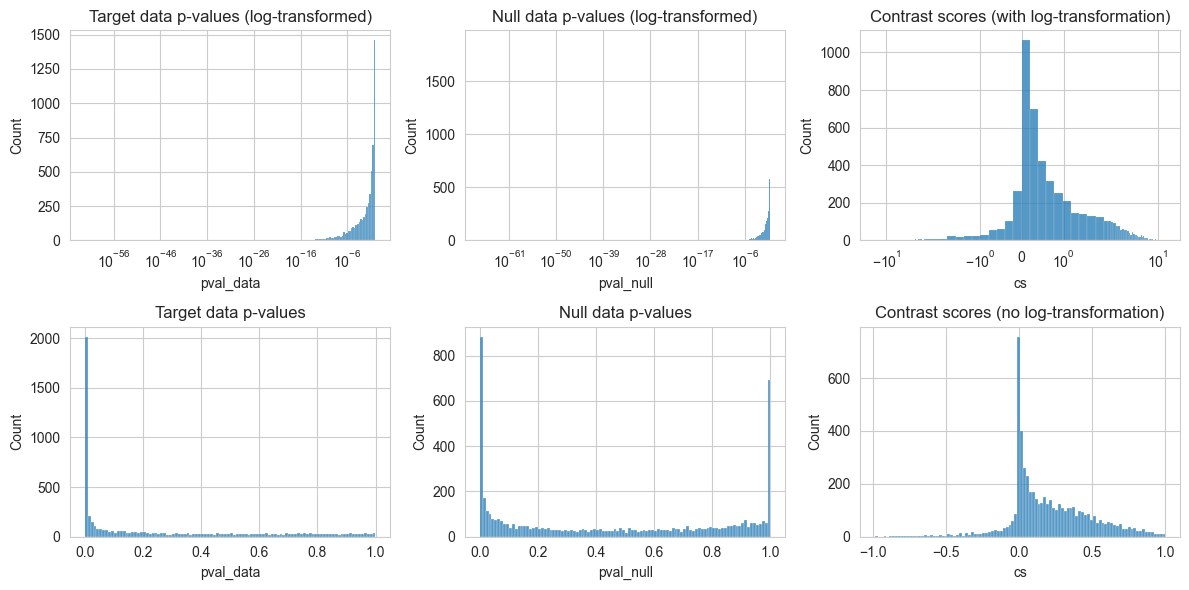

In [47]:
c = "2"

fig, ax = plt.subplots(2, 3, figsize=(12,6))
sns.histplot(pvals_log_gen[c], x="pval_data", ax=ax[0,0], log_scale=True)
ax[0,0].set_title("Target data p-values (log-transformed)")
sns.histplot(pvals_log_gen[c], x="pval_null", ax=ax[0,1], log_scale=True)
ax[0,1].set_title("Null data p-values (log-transformed)")

sns.histplot(pvals_log_gen[c], x="cs", ax=ax[0,2])
ax[0,2].set_title("Contrast scores (with log-transformation)")
ax[0,2].set(xscale="symlog")

sns.histplot(pvals_gen[c], x="pval_data", ax=ax[1,0], bins=100)
ax[1,0].set_title("Target data p-values")
sns.histplot(pvals_gen[c], x="pval_null", ax=ax[1,1], bins=100)
ax[1,1].set_title("Null data p-values")

sns.histplot(pvals_gen[c], x="cs", ax=ax[1,2], bins=100)
ax[1,2].set_title("Contrast scores (no log-transformation)")


plt.tight_layout()
plt.show()

In [48]:
pvals_log_gen["0"]

,pval_data,pval_null,pval_trafo_data,pval_trafo_null,cs,q
PAO1_ID,,,,,,
PA4264,2.438938e-112,5.567315e-62,111.612799,61.254354,50.358445,0.015625
PA4267,2.920381e-94,3.507108e-45,93.534561,44.455051,49.079510,0.015625
PA4244,2.660051e-64,7.037666e-17,63.575110,16.152571,47.422539,0.015625
PA4251,5.612346e-95,3.405209e-49,94.250856,48.467856,45.782999,0.015625
PA4260,1.003996e-113,1.513801e-68,112.998268,67.819931,45.178337,0.015625
...,...,...,...,...,...,...
PA5505,8.743880e-01,7.015507e-07,0.058296,6.153941,-6.095645,1.000000
PA1838,9.027163e-02,3.734446e-08,1.044449,7.427774,-6.383325,1.000000
PA3193,2.333407e-01,1.728862e-08,0.632010,7.762240,-7.130230,1.000000


In [49]:
pvals_log_gen["3"]

,pval_data,pval_null,pval_trafo_data,pval_trafo_null,cs,q
PAO1_ID,,,,,,
PA3744,6.495189e-24,1.496991e-12,23.187408,11.824781,11.362627,0.514607
PA1585,4.316697e-15,4.777740e-04,14.364848,3.320778,11.044071,0.514607
PA0859,1.113857e-14,4.350761e-05,13.953171,4.361435,9.591736,0.514607
PA2742,6.116928e-13,1.927132e-03,12.213467,2.715088,9.498378,0.514607
PA2901,1.999530e-15,2.414313e-06,14.699072,5.617206,9.081866,0.514607
...,...,...,...,...,...,...
PA4256,1.057088e-18,4.534919e-63,17.975889,62.343431,-44.367542,1.000000
PA4264,4.986440e-16,5.567315e-62,15.302209,61.254354,-45.952145,1.000000
PA4260,7.502146e-22,1.513801e-68,21.124815,67.819931,-46.695117,1.000000


SignificanceResult(statistic=0.9999999062055832, pvalue=0.0)
[[1.        0.9439868]
 [0.9439868 1.       ]]


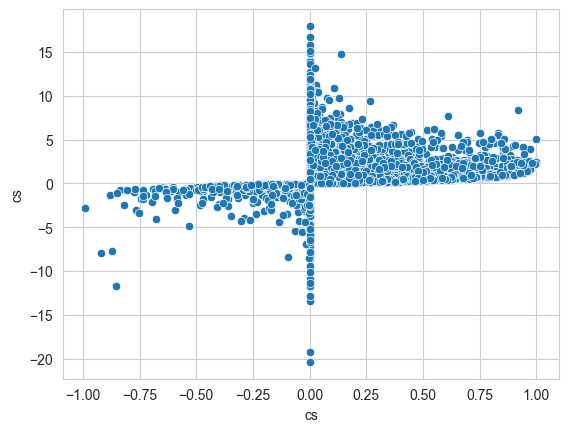

In [50]:
sns.scatterplot(x = pvals_gen["2"]["cs"], y = pvals_log_gen["2"]["cs"])

from scipy.stats import spearmanr
print(spearmanr(pvals_gen["2"]["cs"], pvals_log_gen["2"]["cs"]))
print(np.corrcoef(pvals_gen["2"]["cs"], pvals_log_gen["2"]["cs"]))


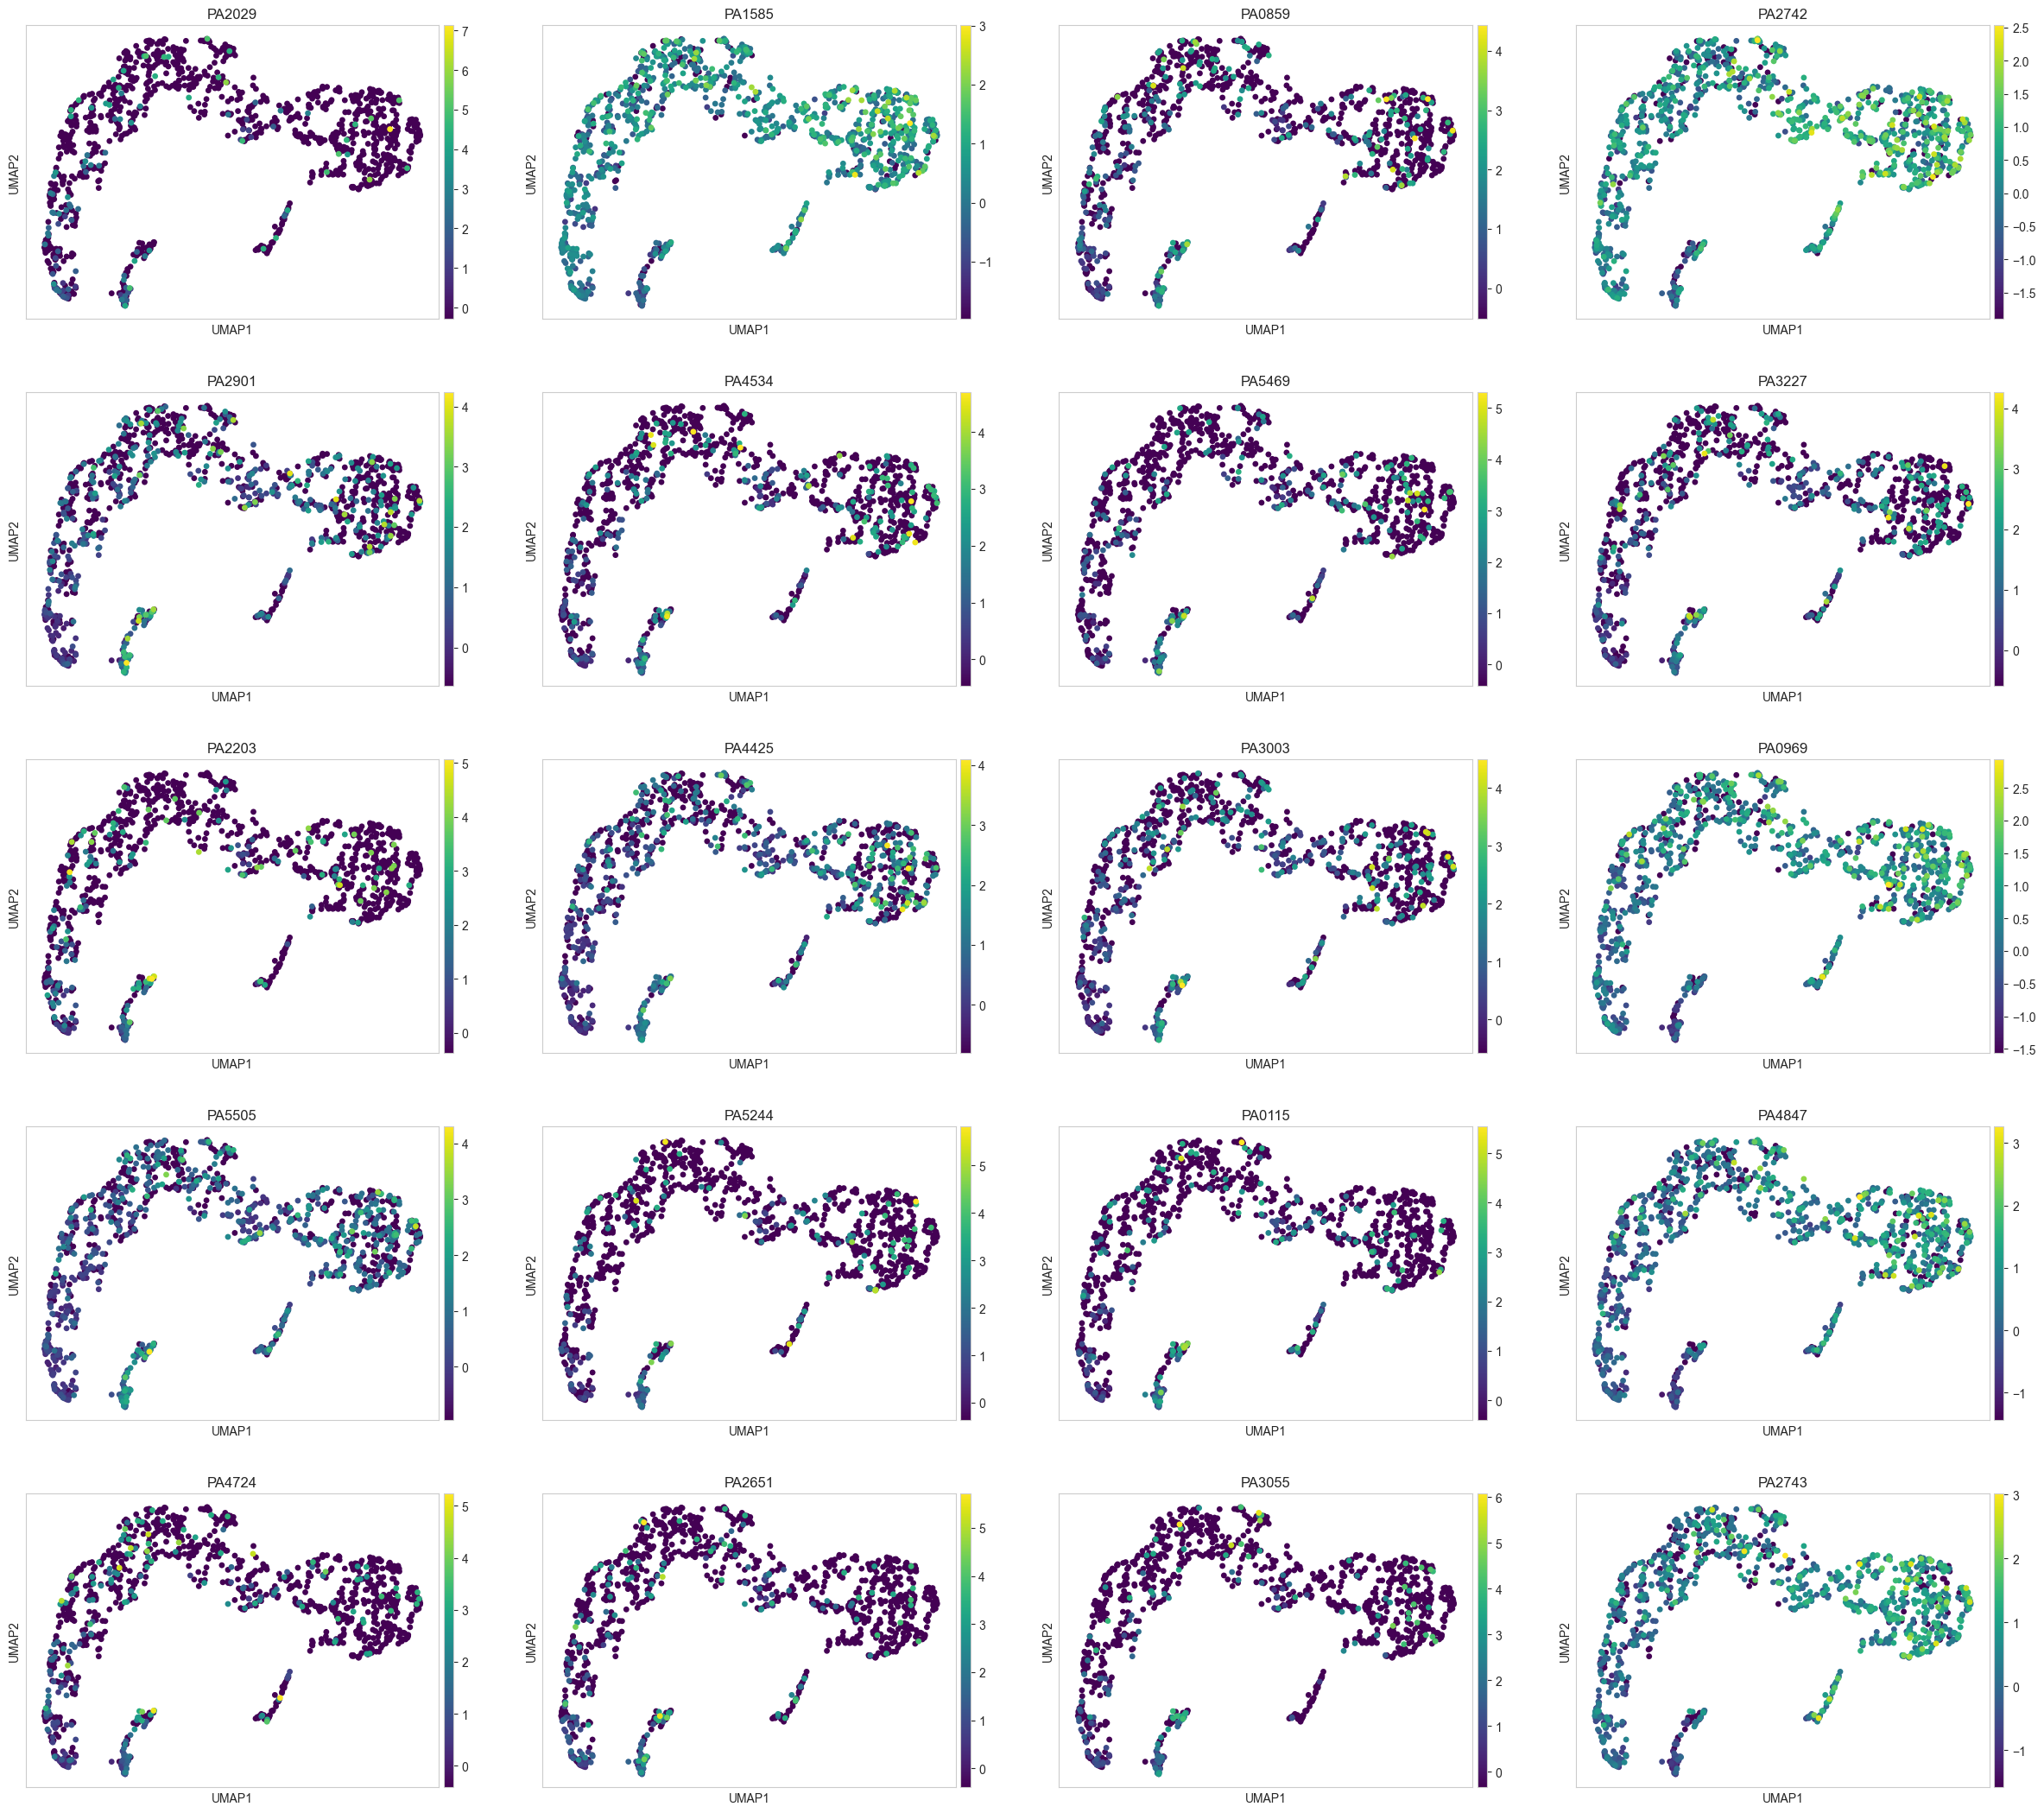

In [51]:
sc.pl.umap(data_gene, color=pvals_log_gen["3"].sort_values("q", ascending=True).index.tolist()[:20], cmap="viridis")


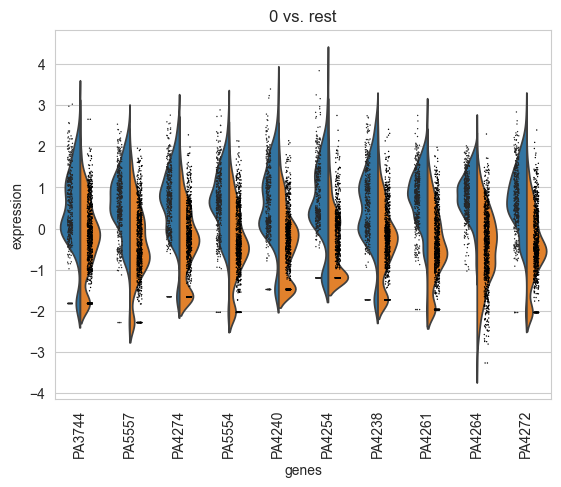

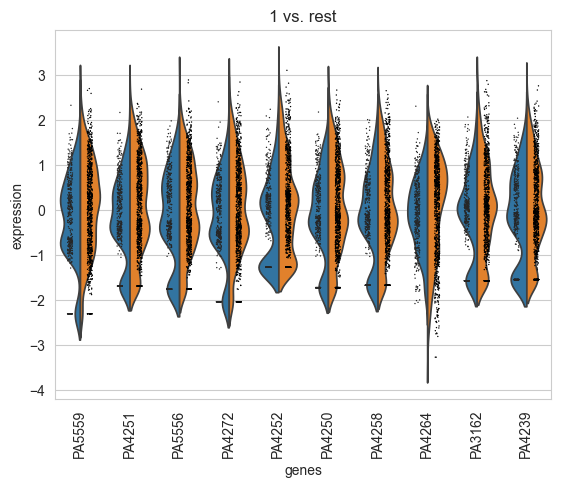

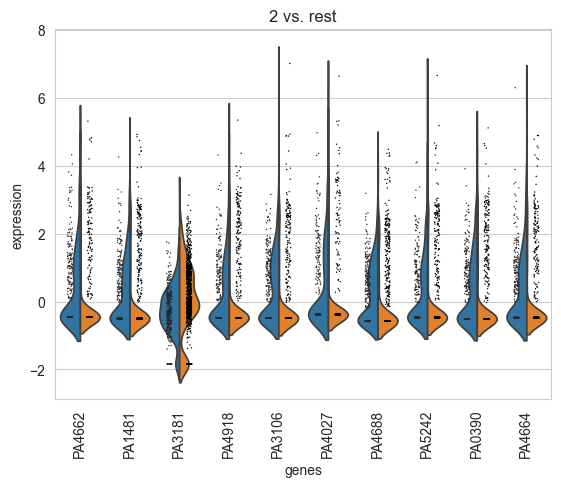

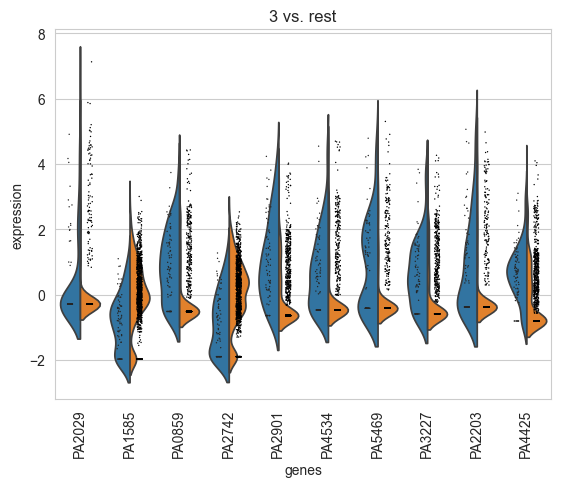

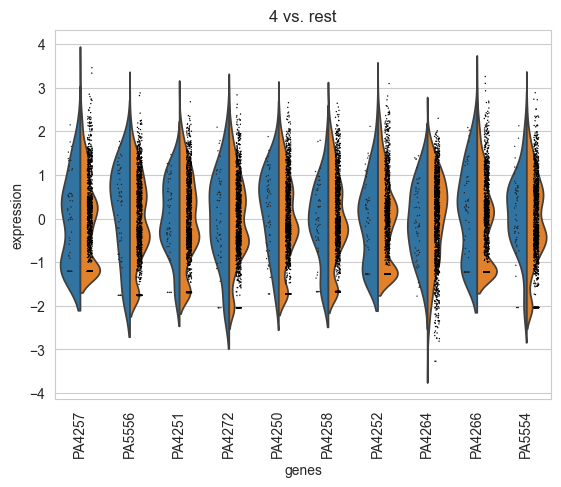

In [52]:
nclust = len(np.unique(data_gene.obs["leiden_opt"]))

for i in range(nclust):
    sc.pl.rank_genes_groups_violin(data_gene, groups=str(i), gene_names=pvals_log_gen[str(i)].sort_values("q", ascending=True).index.tolist()[:10])

In [53]:
pvals_log_gen["3"].to_csv("pvals_3.csv")

# Diagnosing pval_null=1

In [54]:
data_null_gen.uns[""]

AnnData object with n_obs × n_vars = 1255 × 5540
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'leiden'
    var: 'var_counts', 'mean_counts', 'gene_mean', 'gene_var', 'mean_var_diff', 'gene_dist', 'est_mean', 'est_overdisp', 'est_zero_inflation', 'n_cells_by_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mean', 'std'
    uns: 'leiden', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'vst_counts'
    obsp: 'connectivities', 'distances'

In [86]:
null_genes = data_null_gen[:, (pval_null_gen > 0.999).values]
null_genes

View of AnnData object with n_obs × n_vars = 1255 × 641
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'leiden'
    var: 'var_counts', 'mean_counts', 'gene_mean', 'gene_var', 'mean_var_diff', 'gene_dist', 'est_mean', 'est_overdisp', 'est_zero_inflation', 'n_cells_by_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mean', 'std'
    uns: 'leiden', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'vst_counts'
    obsp: 'connectivities', 'distances'

[(0.0, 10.0)]

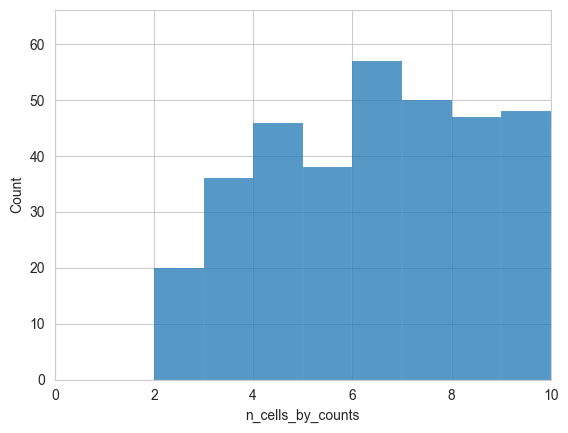

In [146]:
g = sns.histplot(data_gene.var["n_cells_by_counts"], binwidth=1)
g.set(xlim=(0, 10))

In [126]:
null_genes.var

,var_counts,mean_counts,gene_mean,gene_var,mean_var_diff,gene_dist,est_mean,est_overdisp,est_zero_inflation,n_cells_by_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,mean,std
PAO1_ID,,,,,,,,,,,,,,,,
PA0021,0.003968,0.003984,0.003984,0.003968,0.000016,poi,0.003989,inf,0.0,5,0.003976,99.601594,5.0,1.791759,inf,NaN
PA0028,0.007120,0.007171,0.007171,0.007120,0.000051,poi,0.007172,inf,0.0,9,0.007146,99.282869,9.0,2.302585,inf,NaN
PA0029,0.013362,0.013546,0.013546,0.013362,0.000183,poi,0.013546,inf,0.0,17,0.013455,98.645418,17.0,2.890372,inf,NaN
PA0051,0.011031,0.011155,0.011155,0.011031,0.000124,poi,0.011157,inf,0.0,14,0.011094,98.884462,14.0,2.708050,inf,NaN
PA0057,0.005547,0.005578,0.005578,0.005547,0.000031,poi,0.005579,inf,0.0,7,0.005562,99.442231,7.0,2.079442,inf,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PA5432,0.031602,0.032669,0.032669,0.031602,0.001067,poi,0.032670,inf,0.0,41,0.032147,96.733068,41.0,3.737670,inf,NaN
PA5460,0.014910,0.015139,0.015139,0.014910,0.000229,poi,0.015140,inf,0.0,19,0.015026,98.486056,19.0,2.995732,inf,NaN
PA5482,0.005547,0.005578,0.005578,0.005547,0.000031,poi,0.005579,inf,0.0,7,0.005562,99.442231,7.0,2.079442,inf,NaN


In [153]:
data_gene.var

,feature_types,genome,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,PAO1_ID,TU_ID,...,pval_cluster_4_gen,q_cluster_4_gen,DE_cluster_4_gen,gene_mean,gene_var,mean_var_diff,gene_dist,est_mean,est_overdisp,est_zero_inflation
PAO1_ID,,,,,,,,,,,,,,,,,,,,,
PA0001,Gene Expression,PA01,508,0.529880,0.425190,59.521912,665.0,6.501290,PA0001,1,...,0.138457,1.0,False,0.529880,0.555083,-0.025203,nb,0.529876,11.345427,0.0
PA0002,Gene Expression,PA01,383,0.399203,0.335903,69.482072,501.0,6.218600,PA0002,1,...,0.386305,1.0,False,0.399203,0.491633,-0.092430,nb,0.399202,1.894768,0.0
PA0003,Gene Expression,PA01,604,0.728287,0.547131,51.872510,914.0,6.818924,PA0003,1,...,0.560355,1.0,False,0.728287,1.023383,-0.295096,nb,0.728287,2.417572,0.0
PA0004,Gene Expression,PA01,310,0.311554,0.271213,75.298805,391.0,5.971262,PA0004,1,...,0.926639,1.0,False,0.311554,0.372257,-0.060703,nb,0.311550,1.578899,0.0
PA0005,Gene Expression,PA01,108,0.103586,0.098565,91.394422,130.0,4.875197,PA0005,2,...,0.365792,1.0,False,0.103586,0.131103,-0.027517,nb,0.103583,0.336141,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PA5566,Gene Expression,PA01,6,0.004781,0.004769,99.521912,6.0,1.945910,PA5566,3750,...,0.949943,1.0,False,0.004781,0.004758,0.000023,poi,0.004783,inf,0.0
PA5567,Gene Expression,PA01,127,0.117928,0.111477,89.880478,148.0,5.003946,PA5567,3751,...,0.672371,1.0,False,0.117928,0.137487,-0.019559,nb,0.117935,0.578562,0.0
PA5568,Gene Expression,PA01,466,0.506773,0.409970,62.868526,636.0,6.456770,PA5568,3752,...,0.979056,1.0,False,0.506773,0.598958,-0.092185,nb,0.506773,2.762347,0.0


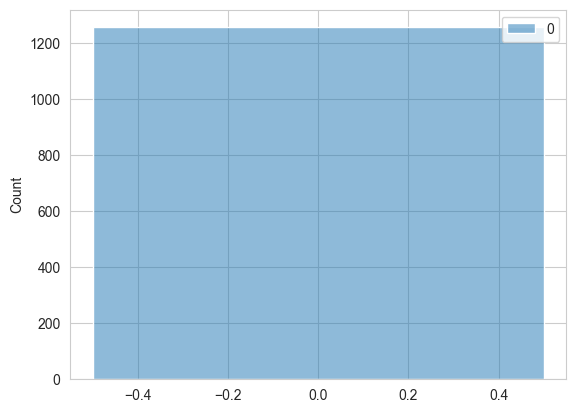

(array([1519]),)


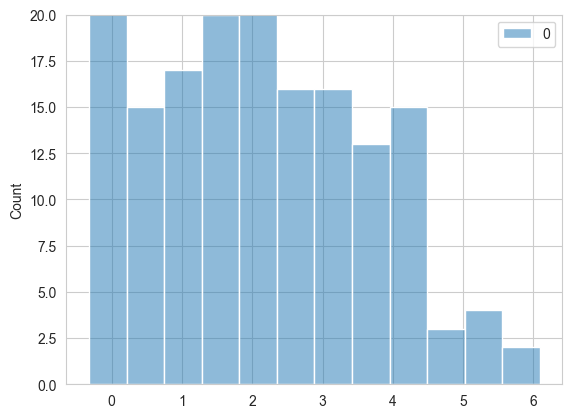

In [152]:
sns.histplot(data_null_gen[:, "PA1530"].X)
plt.show()
g = sns.histplot(data_gene[:, "PA1530"].X)
g.set(ylim=(0,20))

print(np.where(data_gene.var_names == "PA1530"))

In [138]:
importlib.reload(cd)

data_gen_noscale, R_est_noscale = cd.generate_nb_data_copula(data_gene, rng_seed=5678, nb_flavor="statsmod_auto",
                                                  auto_dist=True, correct_var=True, return_R=True, corr_factor=1,
                                                  R_est=None, check_pd=True)


xmin = 1.1353288256658716

# Generate scaling matrix
cor_orig = cd.schaefer_strimmer(data_gene.layers["counts"].toarray(), use_corr=True)
factor_cor = (np.abs(cor_orig) > 0.1)
cf = factor_cor * xmin
cf[cf == 0] = 1
np.fill_diagonal(cf, 1)

data_null_gen2, R_est = cd.generate_nb_data_copula(data_gene, rng_seed=5678, nb_flavor="statsmod_auto",
                                                  auto_dist=True, correct_var=True, return_R=True,
                                                  corr_factor=cf, R_est=R_est_noscale, check_pd=False)

In [139]:
data_poi = data_gene[:, (pval_null_gen > 0.999).values].copy()

In [140]:
importlib.reload(cd)

n, p = data_gene.X.shape
data_null_gen3, _ = cd.generate_nb_data_copula(data_poi, rng_seed=5678, nb_flavor="statsmod_auto", auto_dist=True, correct_var=True, return_R=True)
data_null_gen3

AnnData object with n_obs × n_vars = 1255 × 641

PA0021


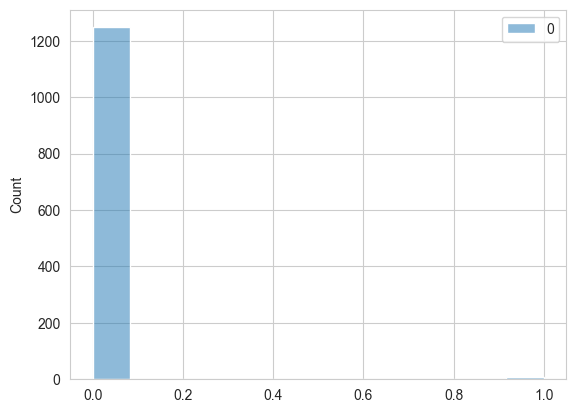

PA0028


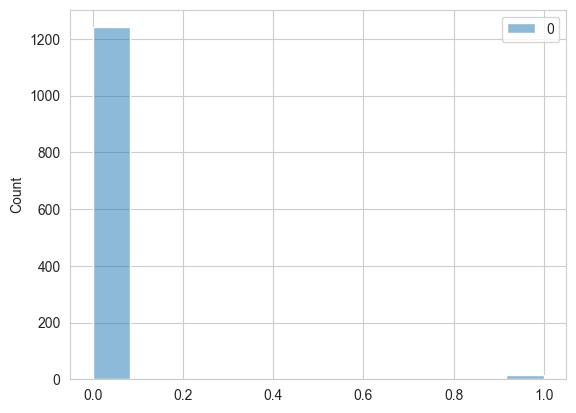

PA0029


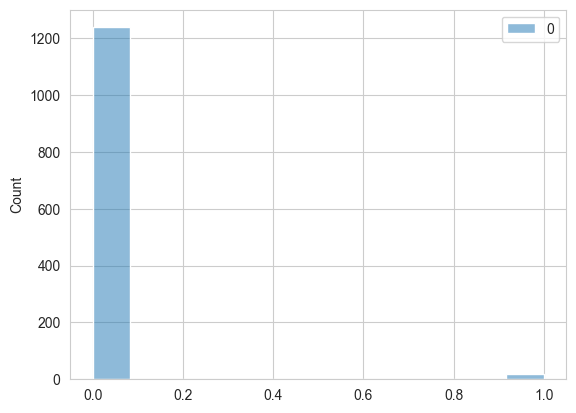

PA0051


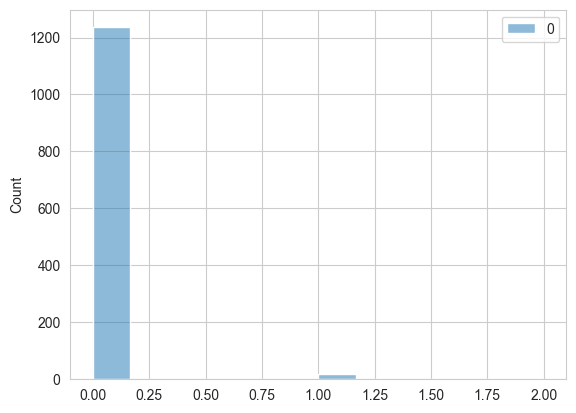

PA0057


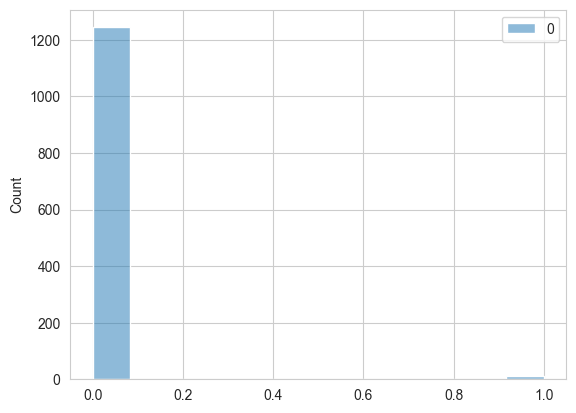

PA0109


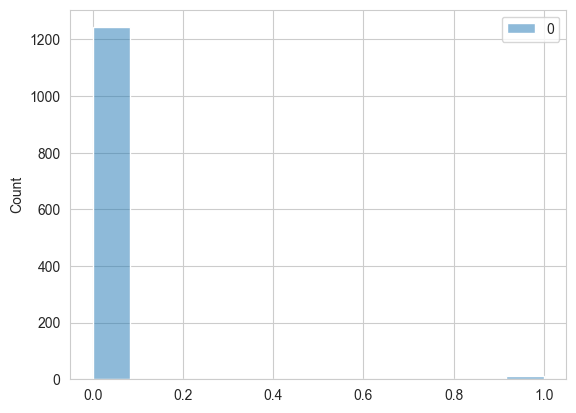

PA0121


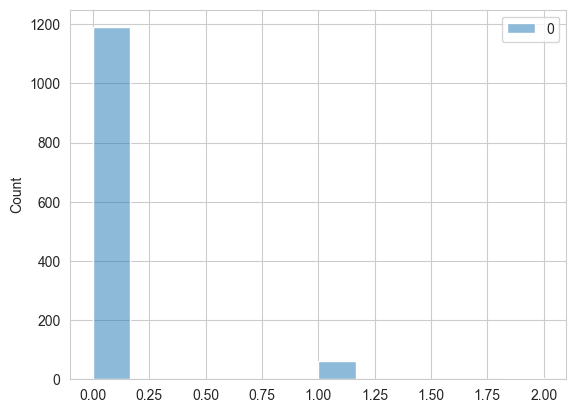

PA0135


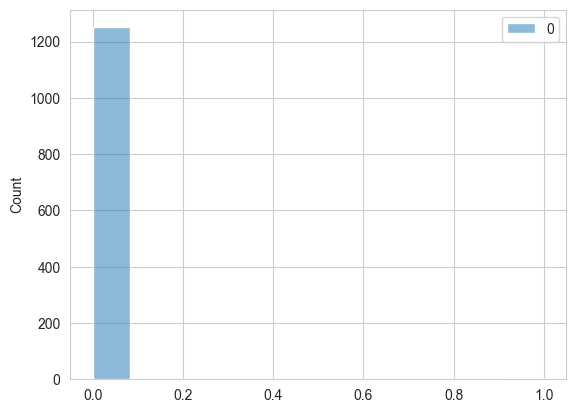

PA0136


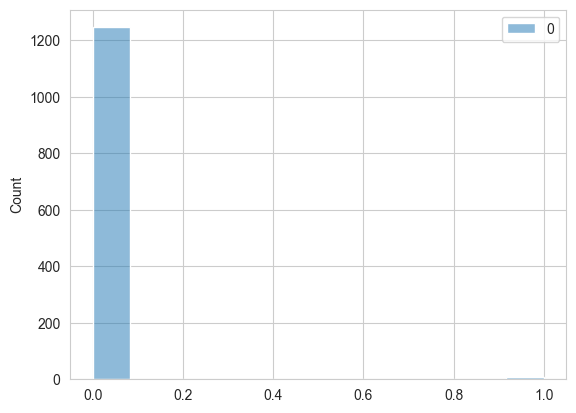

PA0137


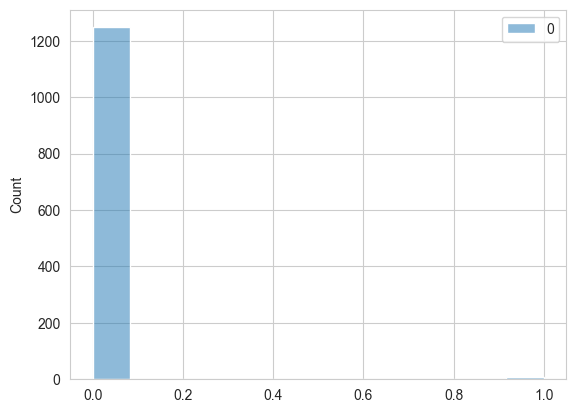

In [141]:
goi = null_genes.var_names

for i in goi[:10]:
    print(i)
    sns.histplot(data_null_gen3[:, i].X)
    plt.show()


PA0021


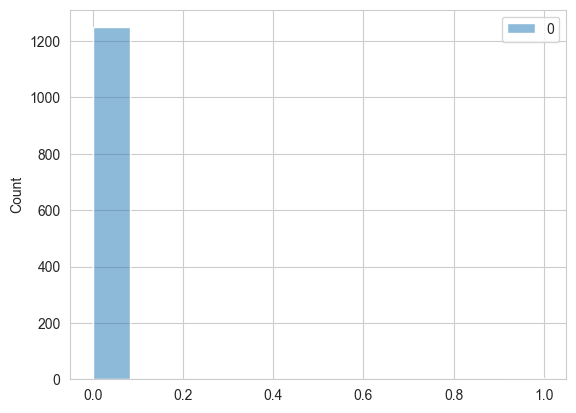

PA0028


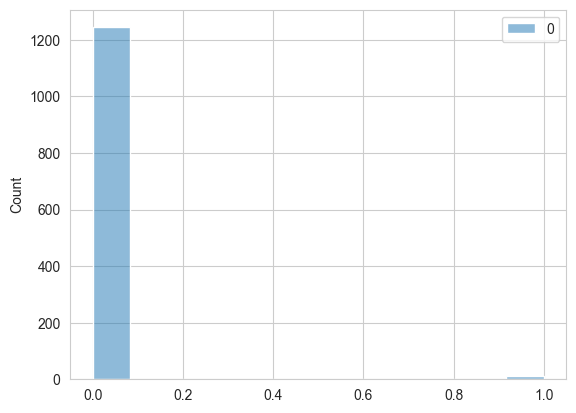

PA0029


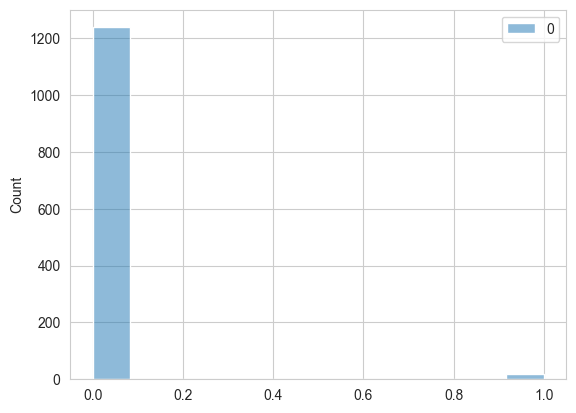

PA0051


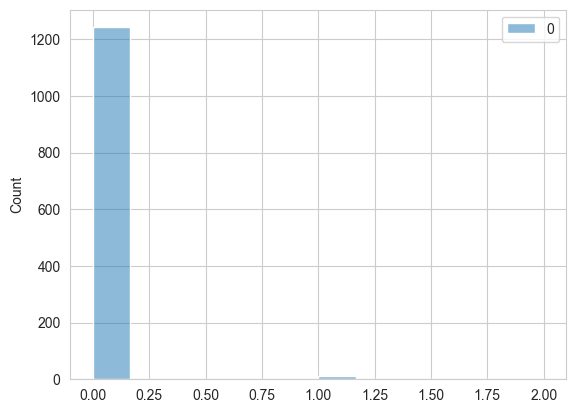

PA0057


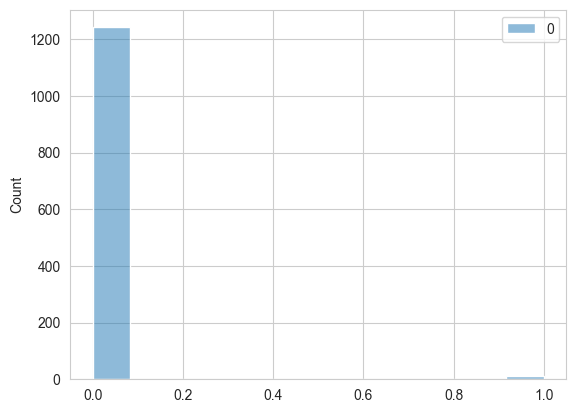

PA0109


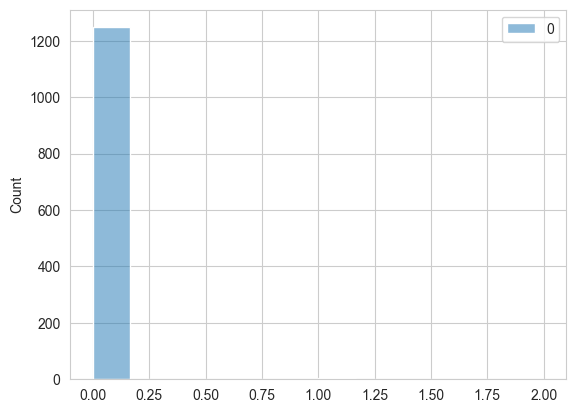

PA0121


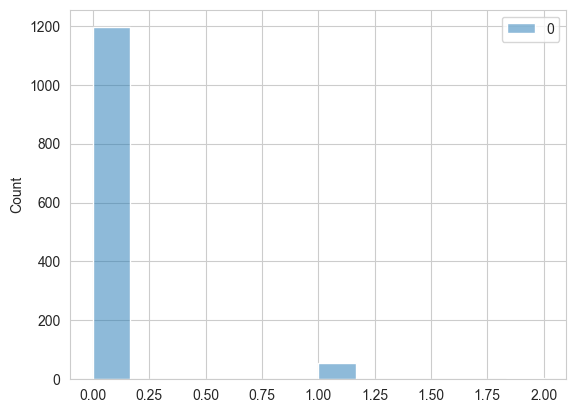

PA0135


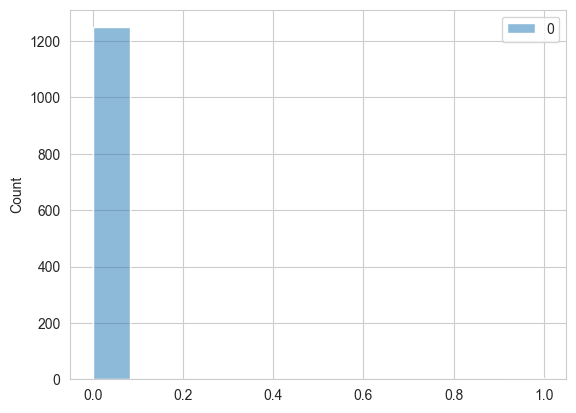

PA0136


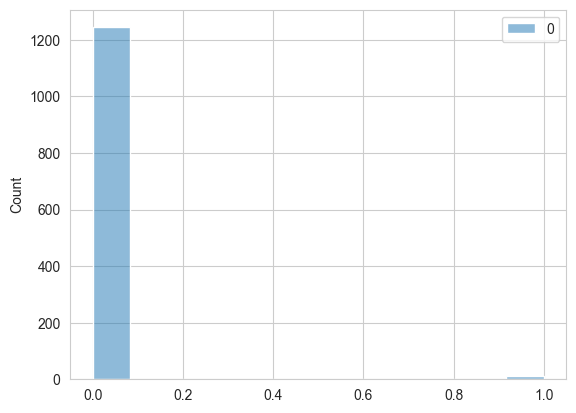

PA0137


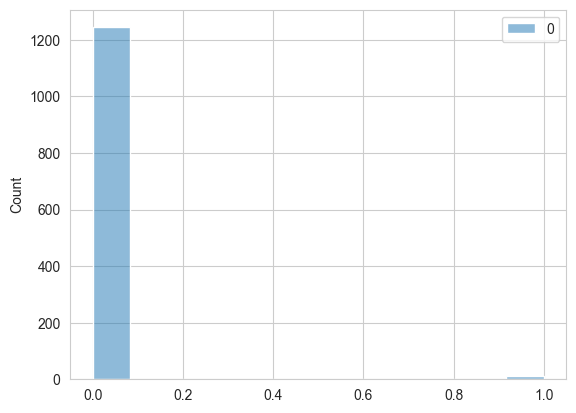

In [142]:
for i in goi[:10]:
    print(i)
    sns.histplot(data_gene[:, i].layers["counts"].toarray())
    plt.show()

PA0021


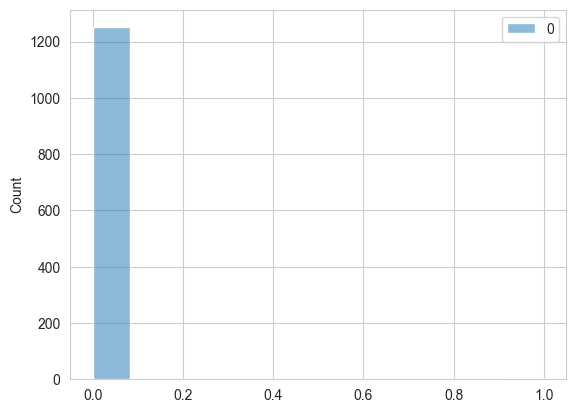

PA0028


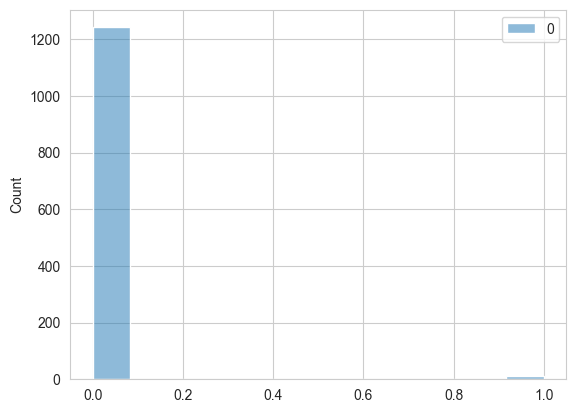

PA0029


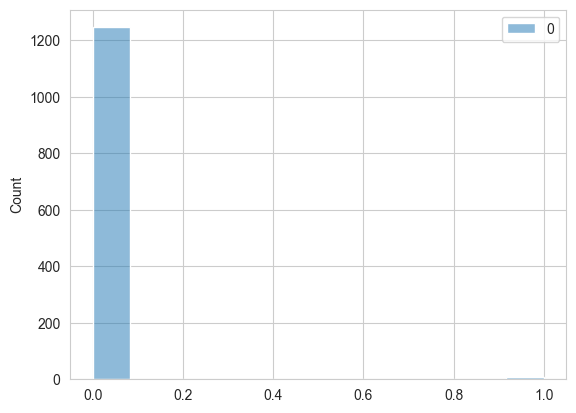

PA0051


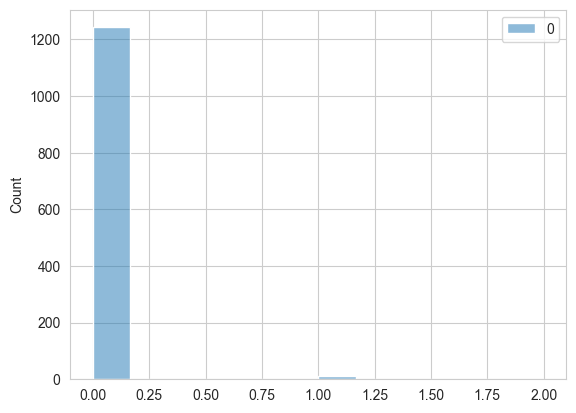

PA0057


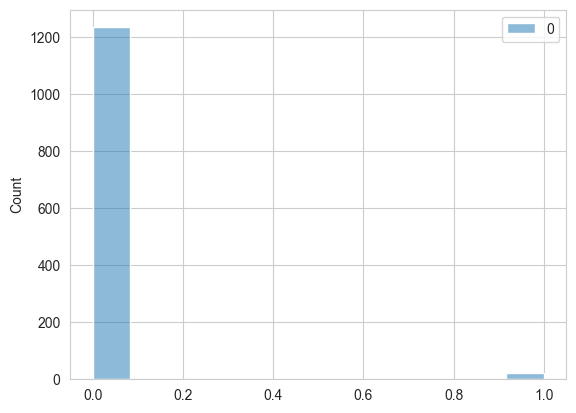

PA0109


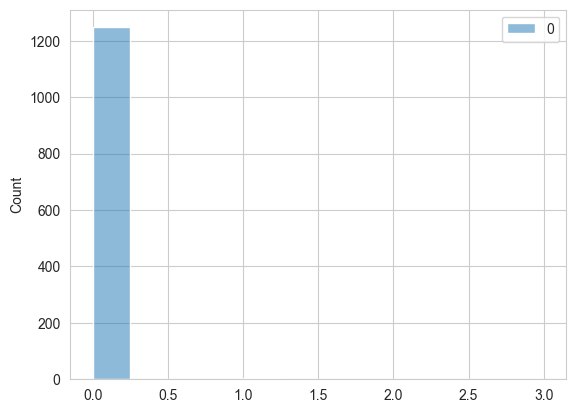

PA0121


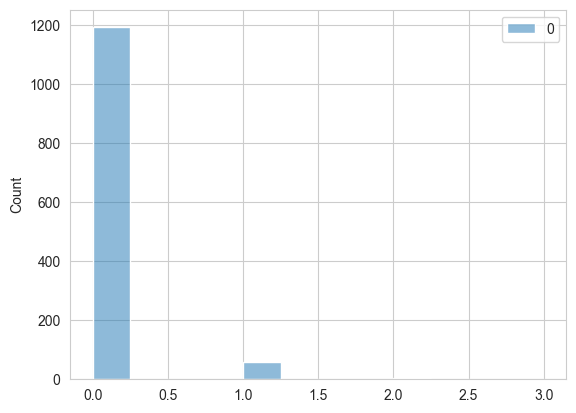

PA0135


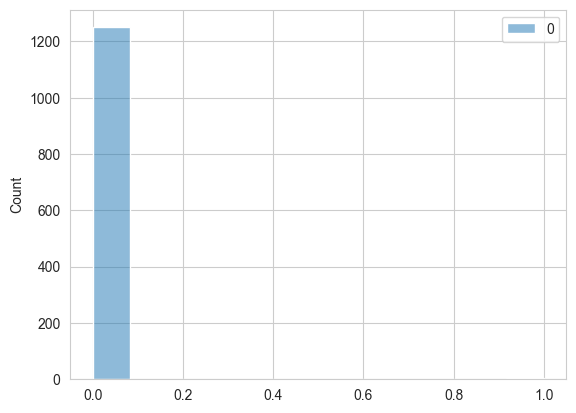

PA0136


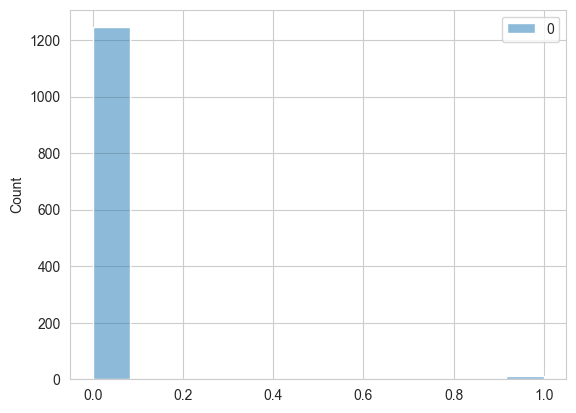

PA0137


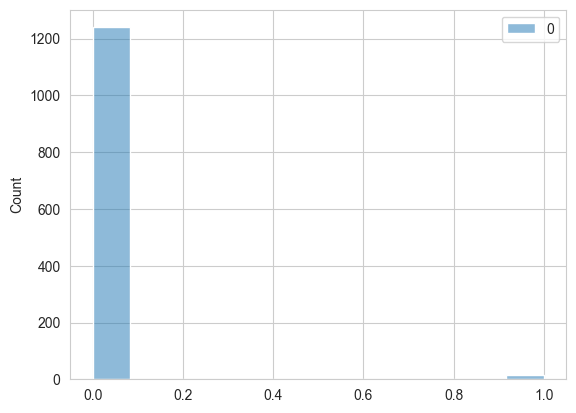

In [143]:
for i in goi[:10]:
    print(i)
    sns.histplot(data_null_gen2[:, i].X)
    plt.show()

In [151]:
from statsmodels.discrete.discrete_model import NegativeBinomialP, NegativeBinomial, Poisson, GeneralizedPoisson
from statsmodels.discrete.count_model import (ZeroInflatedNegativeBinomialP, ZeroInflatedPoisson,
                                              ZeroInflatedGeneralizedPoisson)


gi = 1519
    
dat = (data_gene.layers["counts"].toarray())[:, gi].T
print(dat)
print(np.mean(dat))
print(np.var(dat))
# sns.histplot(dat)


model_zip = ZeroInflatedPoisson(dat, np.ones(n))
res_zip = model_zip.fit(method='bfgs', maxiter=5000, maxfun=5000)
print(res_zip.summary())

model_p = Poisson(dat, np.ones(n))
res_p = model_p.fit(method='bfgs', maxiter=5000, maxfun=5000)
print(res_p.summary())

[0. 0. 0. ... 0. 0. 0.]
0.12669322709163347
0.1329528102728528
Optimization terminated successfully.
         Current function value: 0.395346
         Iterations: 15
         Function evaluations: 18
         Gradient evaluations: 18
                     ZeroInflatedPoisson Regression Results                    
Dep. Variable:                       y   No. Observations:                 1255
Model:             ZeroInflatedPoisson   Df Residuals:                     1254
Method:                            MLE   Df Model:                            0
Date:                 Mon, 25 Mar 2024   Pseudo R-squ.:              -1.149e-08
Time:                         10:05:19   Log-Likelihood:                -496.16
converged:                        True   LL-Null:                       -496.16
Covariance Type:             nonrobust   LLR p-value:                       nan
                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------

In [156]:
from scipy.special import gammaln, factorial, expit
np.exp(-0.7405)

0.4768754181925747